In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
base_dir = 'cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Vortrainierte Modelle verwenden

## Vortrainierte Layers


![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)


In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
conv_base.trainable = False

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/home/mago1/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 97s 970ms/step - loss: 0.6528 - acc: 0.6217 - val_loss: 0.4586 - val_acc: 0.8300
Epoch 2/5
100/100 [==============================] - 96s 967ms/step - loss: 0.4995 - acc: 0.7819 - val_loss: 0.3787 - val_acc: 0.8500
Epoch 3/5
100/100 [==============================] - 96s 967ms/step - loss: 0.4228 - acc: 0.8207 - val_loss: 0.3383 - val_acc: 0.8690
Epoch 4/5
100/100 [==============================] - 96s 967ms/step - loss: 0.4169 - acc: 0.8203 - val_loss: 0.3098 - val_acc: 0.8710
Epoch 5/5
100/100 [==============================] - 97s 968ms/step - loss: 0.3820 - acc: 0.8306 - val_loss: 0.2953 - val_acc: 0.8730


In [8]:
model.save('cats_and_dogs_small_3.h5')

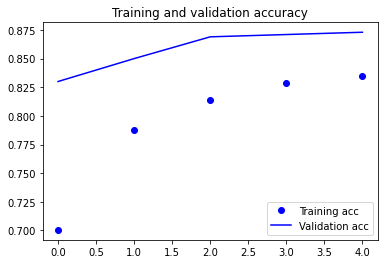

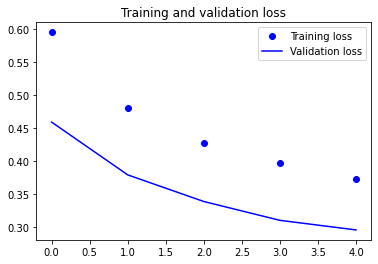

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Finetuning

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=50)

20/20 [==============================] - 49s 3s/step - loss: 0.3984 - acc: 0.8281 - val_loss: 0.2819 - val_acc: 0.8820


In [13]:
model.save('cats_and_dogs_small_4.h5')

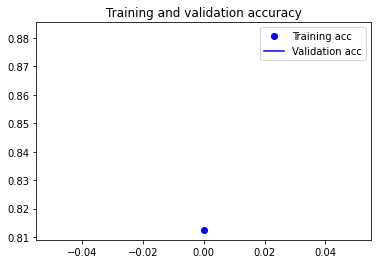

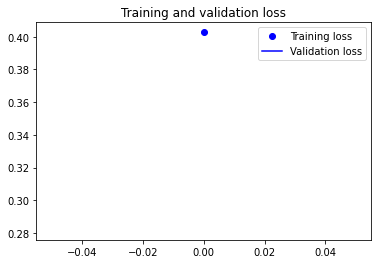

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/home/mago1/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.8820000290870667


# Übung:

Im folgenden wird ein vortrainiertes Modell geladen. Betrachte das Modell. Wie viele Layer hat es? Um was für ein Modell handelt es sich?

* Setze einen neuen Classifier darauf welcher die Bilddaten aus cifar10 klassifiziert.

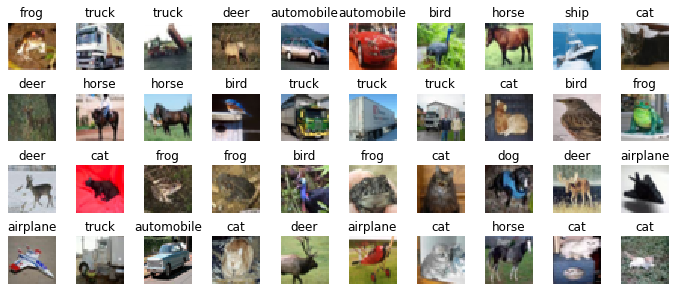

In [16]:
(train_data, train_target), (test_data, test_target) = keras.datasets.cifar10.load_data()

label_names = {
    0: 'airplane', 
    1: 'automobile',
    2: 'bird', 
    3: 'cat',
    4: 'deer',
    5: 'dog', 
    6: 'frog', 
    7: 'horse', 
    8: 'ship', 
    9: 'truck'
}
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(train_data[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(label_names[int(train_target[index])], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

train_data = train_data.astype('float32') / 255 

test_data = test_data.astype('float32') / 255

In [17]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))
